In [19]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_theme(style="whitegrid") 

In [20]:
df = pd.read_csv('../data/processed/housing_clean.csv')
df.head()

,price,lotsize,bedrooms,bathrms,stories,garagepl,driveway_yes,recroom_yes,fullbase_yes,gashw_yes,airco_yes,prefarea_yes
0,42000,5850,3,1,2,1,1,0,1,0,0,0
1,38500,4000,2,1,1,0,1,0,0,0,0,0
2,49500,3060,3,1,1,0,1,0,0,0,0,0
3,60500,6650,3,1,2,0,1,1,0,0,0,0
4,61000,6360,2,1,1,0,1,0,0,0,0,0


In [21]:
print(f"Dimentions: {df.shape[0]} lignes, {df.shape[1]} colonnes")

Dimentions: 546 lignes, 12 colonnes


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   price         546 non-null    int64
 1   lotsize       546 non-null    int64
 2   bedrooms      546 non-null    int64
 3   bathrms       546 non-null    int64
 4   stories       546 non-null    int64
 5   garagepl      546 non-null    int64
 6   driveway_yes  546 non-null    int64
 7   recroom_yes   546 non-null    int64
 8   fullbase_yes  546 non-null    int64
 9   gashw_yes     546 non-null    int64
 10  airco_yes     546 non-null    int64
 11  prefarea_yes  546 non-null    int64
dtypes: int64(12)
memory usage: 51.3 KB


**on commence par les separer, avec X features, y le target et on fait un split de 80%pour le train**

In [23]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"On va entrainera avec: {X_train.shape[0]} maisons")
print(f"oN VA tester avec: {X_test.shape[0]} maisons")

On va entrainera avec: 436 maisons
oN VA tester avec: 110 maisons


**Ensuite c'est l'netrainment lightGBM, c'est un algo de gradientBoosting**
- cela c'est la creation des centaines petits arbres de decisions, où chque arbre corrige le precedent.
- n_estimators=100 veut dire qu'on va creer 100 arbres

In [24]:
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [25]:
print("Training model")
model.fit(X_train, y_train)
print("Training Finalisé")

Training model
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 10
[LightGBM] [Info] Start training from score 68937.711009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

**On fait le test sans les reponses pour evaluer les predictions**

In [26]:
y_pred = model.predict(X_test)

**On comapre les premiers predictiona avec les vrais valeurs**

In [27]:
comparison = pd.DataFrame({'Reel': y_test.values, 'Predicted': y_pred})
comparison.head()

,Reel,Predicted
0,80000,67955.530241
1,47000,58369.366844
2,130000,116035.548365
3,47000,64319.344985
4,59000,61853.180587


**Evaluation MAE R2**

- MAE : En moyenne, de combien de dollars avons-nous manqué la valeur ?

- R² : Dans quelle mesure le modèle explique-t-il la variance (de 0 à 1) ?

In [28]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE : ${mae:,.2f}")
print(f"RMSE : ${rmse:,.2f}")
print(f"R2(precisionn): {r2:.4f}")

MAE : $11,884.73
RMSE : $16,103.94
R2(precisionn): 0.6118


**2. Diagramme de dispersion (Valeurs réelles vs Valeurs prévues)**
- si c'est un model parfait tous les points seront proche de la ligne rouge

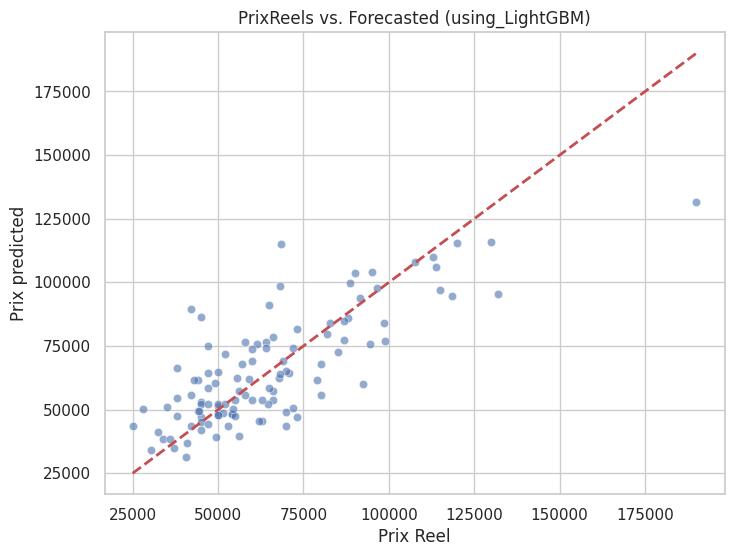

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.xlabel("Prix Reel")
plt.ylabel("Prix predicted")
plt.title("PrixReels vs. Forecasted (using_LightGBM)")
plt.show()

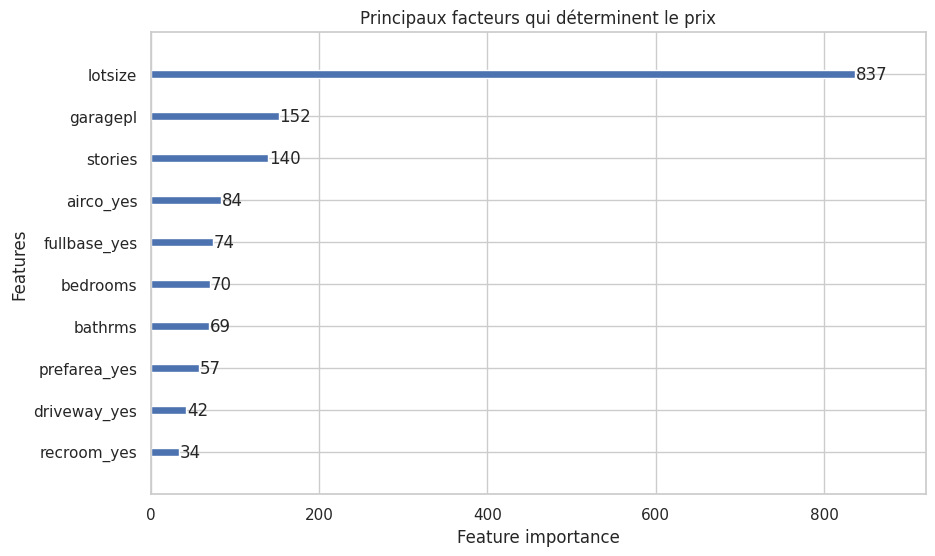

In [30]:
lgb.plot_importance(model, max_num_features=10, figsize=(10, 6), title="Principaux facteurs qui déterminent le prix")
plt.show()

**On enregistre le artifact**
- comme notre R2 es au tour 0.6 on peut enregistre le model commo premier version

In [31]:
model_filename = '../models/lightgbm_house_prices_v1.pkl'
joblib.dump(model, model_filename)
print(f"Model enregistré comme: {model_filename}")

Model enregistré comme: ../models/lightgbm_house_prices_v1.pkl


**Conclusions**
- En termes commerciaux, cela signifie que lemodèle est capable d'expliquer **61 %** de la variation des prix, mais qu'il subsiste une marge d'erreur considérable (erreur moyenne d'environ **12 000 $ US**).

#### our optimiser ce score avec LightGBM sur un petit jeu de données, nous appliquerons la méthode « Combo Pro » :

**Transformation logarithmique de la cible (Mathématiques) :**

- Problème : l'histogramme montre que les prix présentent une « queue » à droite (quelques maisons très chères). Les modèles n’apprécient pas ce type de distribution ; ils préfèrent des courbes en cloche parfaites.

- **Solution** : Nous lissons les prix à l’aide d’un logarithme. Le modèle apprendra mieux, puis, lors de la prédiction, nous annulerons la transformation.

**Optimisation des hyperparamètres (Ingénierie) :**

- Problème : LightGBM est configuré par défaut pour le Big Data (millions de lignes). Utiliser la configuration par défaut sur 500 lignes revient à installer un moteur de Formule 1 dans un kart : le modèle va dysfonctionner (**surapprentissage**).

- **Solution** : Nous allons limiter le modèle. Nous allons réduire la taille et la simplicité de ses arbres (faible profondeur maximale, faible nombre de feuilles) afin d’améliorer sa capacité de généralisation.